<a href="https://colab.research.google.com/github/seanbenhur/personalized_cancer_diagnosis/blob/master/personalized_cancer_diagnosis_using_ml_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cancer Diagnosis using Machine Learning

Once sequenced, a cancer tumor can have thousands of genetic mutations. But the challenge is distinguishing the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers). 

Currently this interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature.

In this project I have developed a Machine Learning algorithm that automatically classifies genetic variations.



## Import the necessary libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import time
import re
import warnings
import math
from scipy.sparse import hstack
from collections import defaultdict,Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import log_loss, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import  nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
train_variants = pd.read_csv('/content/drive/My Drive/data/personalized medicine/training_variants')
print('Number of observations in trainig variants is',train_variants.shape[0])
print('Number of features in training variants is',train_variants.shape[1])
print(train_variants.head())

Number of observations in trainig variants is 3321
Number of features in training variants is 4
   ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
3   3     CBL                 N454D      3
4   4     CBL                 L399V      4


<p>
    training_variants is a comma separated file containing the description of the genetic mutations used for training. <br>
    Fields are 
    <ul>
        <li><b>ID : </b>the id of the row used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b>the gene where this genetic mutation is located </li>
        <li><b>Variation : </b>the aminoacid change for this mutations </li>
        <li><b>Class :</b> 1-9 the class this genetic mutation has been classified on</li>
    </ul>

### Let's read the text file and  preprocess them

In [5]:
train_text = pd.read_csv('/content/drive/My Drive/data/personalized medicine/training_text',
                         sep='\|\|',engine='python',names=['ID','TEXT'],skiprows=1)
print('Number of observations in training text is',train_text.shape[0])
print('Number of features in training text is', train_text.shape[1])
print(train_text.head())

Number of observations in training text is 3321
Number of features in training text is 2
   ID                                               TEXT
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...
2   2   Abstract Background  Non-small cell lung canc...
3   3  Recent evidence has demonstrated that acquired...
4   4  Oncogenic mutations in the monomeric Casitas B...


In [6]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                pass
                string += word + " "
        
        train_text[column][index] = string      

In [7]:
#text processing stage.
start_time = time.perf_counter()
for index, row in train_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : -134.028845703 seconds


In [8]:
#merging both gene_variations and text data based on ID
result = pd.merge(train_variants, train_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [9]:
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [10]:
print('Number of observations on result  is',result.shape[0])
print('Number of features on result is', result.shape[1])

Number of observations on result  is 3321
Number of features on result is 5


In [11]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [12]:
result.loc[result['TEXT'].isnull(),'TEXT'] = result['Gene'] +'  '+result['Variation']

In [13]:
result[result['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


## Train,Test and Cross-Validation split

In [14]:
y_true = result['Class'].values
result.Gene = result.Gene.str.replace('\s', '_')
result.Variation =  result.Variation.str.replace('\s', '_')
X_train, test_df, y_train, y_test =  train_test_split(result, y_true, stratify=y_true, test_size=0.2)
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [15]:
print('Number of observations in train data:', train_df.shape[0])
print('Number of observations in test data:', test_df.shape[0])
print('Number of observation in cross validation data:', cv_df.shape[0])

Number of observations in train data: 2124
Number of observations in test data: 665
Number of observation in cross validation data: 532


### Distribution of y_i's in all the data sets

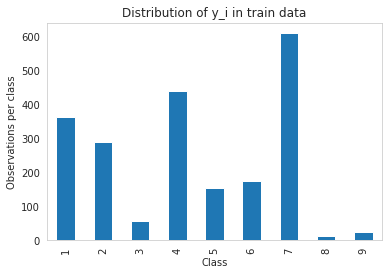

Number of observations in class: 7 : 609 ( 28.672 %)
Number of observations in class: 4 : 439 ( 20.669 %)
Number of observations in class: 1 : 363 ( 17.09 %)
Number of observations in class: 2 : 289 ( 13.606 %)
Number of observations in class: 6 : 176 ( 8.286 %)
Number of observations in class: 5 : 155 ( 7.298 %)
Number of observations in class: 3 : 57 ( 2.684 %)
Number of observations in class: 9 : 24 ( 1.13 %)
Number of observations in class: 8 : 12 ( 0.565 %)
----------------------------------------------------------------------------------------------------


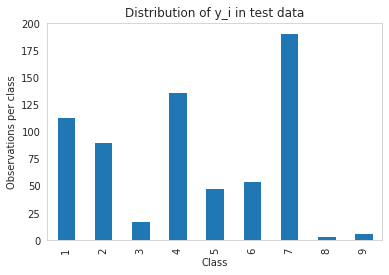

Number of observations in class: 7 : 191 ( 28.722 %)
Number of observations in class: 4 : 137 ( 20.602 %)
Number of observations in class: 1 : 114 ( 17.143 %)
Number of observations in class: 2 : 91 ( 13.684 %)
Number of observations in class: 6 : 55 ( 8.271 %)
Number of observations in class: 5 : 48 ( 7.218 %)
Number of observations in class: 3 : 18 ( 2.707 %)
Number of observations in class: 9 : 7 ( 1.053 %)
Number of observations in class: 8 : 4 ( 0.602 %)
----------------------------------------------------------------------------------------------------


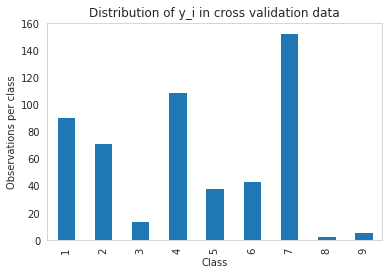

Number of observations in class: 7 : 153 ( 28.759 %)
Number of observations in class: 4 : 110 ( 20.677 %)
Number of observations in class: 1 : 91 ( 17.105 %)
Number of observations in class: 2 : 72 ( 13.534 %)
Number of observations in class: 6 : 44 ( 8.271 %)
Number of observations in class: 5 : 39 ( 7.331 %)
Number of observations in class: 3 : 14 ( 2.632 %)
Number of observations in class: 9 : 6 ( 1.128 %)
Number of observations in class: 8 : 3 ( 0.564 %)


In [16]:
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Observations per class')
plt.title('Distribution of y_i in train data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of observations in class:',i+1,':',train_class_distribution.values[i],'(',
         np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

print('-'*100)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Observations per class')
plt.title('Distribution of y_i in test data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of observations in class:',i+1,':',test_class_distribution.values[i],'(',
         np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')
    
print('-'*100)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Observations per class')
plt.title('Distribution of y_i in cross validation data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of observations in class:',i+1,':',cv_class_distribution.values[i],'(',
         np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')

## Prediction using a random model

In [17]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    B = (C/C.sum(axis=0))
    labels = [1,2,3,4,5,6,7,8,9]

Log loss on cross validation data using random model 2.4709005538936095
Log loss on test data using random model 2.424739229957468
-------------------- Confusion matrix --------------------


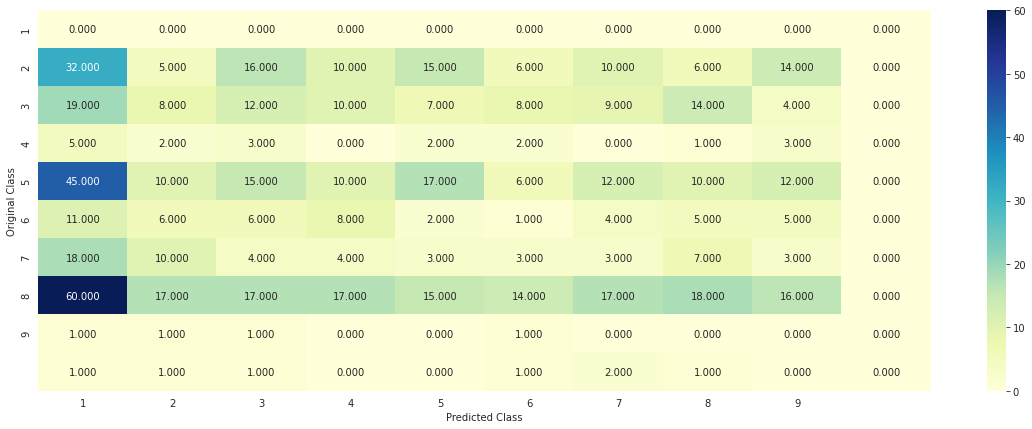

-------------------- Precision matrix (Columm Sum=1) --------------------


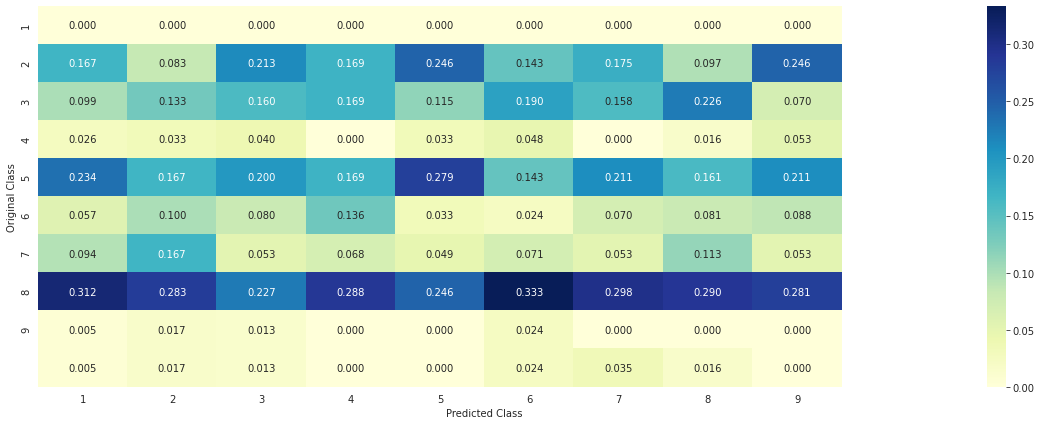

-------------------- Recall matrix (Row sum=1) --------------------


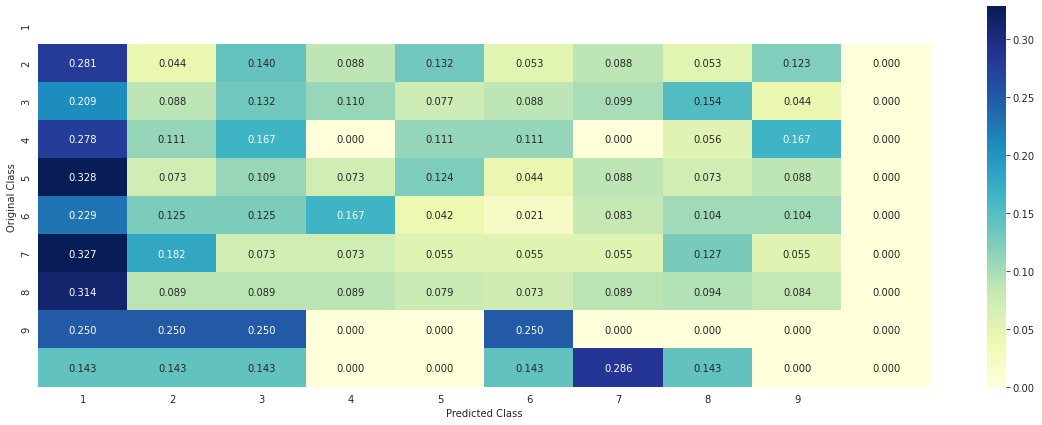

In [18]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
len_test_data = test_df.shape[0]
len_cv_data = cv_df.shape[0]

#create an output array that has exactly the same size as cv data
cv_predicted_y = np.zeros((len_cv_data, 9))
for i in range(len_cv_data):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0]) 
print('Log loss on cross validation data using random model', log_loss(y_cv,cv_predicted_y, eps=1e-15))
#test set error
#create an output array that has exactly the same as the test data
test_predicted_y = np.zeros((len_test_data,9))
for i in range(len_cv_data):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0]) 
print('Log loss on test data using random model', log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y = np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

# Univariate Analysis

In [19]:
#code for response coding with laplace smoothing
#alpha: used for laplace smoothing
#feature: ['gene', 'variation']
#df : ['train_df', 'test_df', 'cv_df']
#algorithm
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

#get_gv_fea_dict : Get Gene Variation feature dict
def get_gv_fea_dict(alpha, feature, df):
    value_count = train_df[feature].value_counts()
    #gv_dict : Gene variation dict, which contains the probabilty array for each gene and variation
    gv_dict = dict()
    #denominator will contain the no. of times the gene occured in the whole data
    for i, denominator in value_count.items():
        #vec will contain (p(yi==1/Gi)) probability of gene/variation belongs to particular class
        vec =[]
        for k in range(1,10):
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            #cls_cnt.shape[0] will contain the  number of times that the feature occured on the whole data
            vec.append((cls_cnt.shape[0]+alpha*10)/(denominator+90*alpha))
        #add the gene/variation to the dict as a key
        gv_dict[i] = vec
    return  gv_dict

#get gene variation faeture
def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha,feature,df)
    value_count = train_df[feature].value_counts()
    
    gv_fea = []
    for index, row in df.iterrows():
        if  row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    
    return gv_fea
    

## Univariate analysis on gene feature

In [20]:
unique_genes = train_df['Gene'].value_counts()
unique_genes_percent = train_df['Gene'].value_counts(normalize=True)
print('Number of unique genes: ',unique_genes.shape[0])
#the top genes that occured most
print(unique_genes.head(10))
print(unique_genes_percent.head(10))

Number of unique genes:  243
BRCA1     171
TP53       95
EGFR       89
PTEN       84
BRCA2      83
KIT        60
BRAF       55
ALK        49
ERBB2      40
PDGFRA     38
Name: Gene, dtype: int64
BRCA1     0.080508
TP53      0.044727
EGFR      0.041902
PTEN      0.039548
BRCA2     0.039077
KIT       0.028249
BRAF      0.025895
ALK       0.023070
ERBB2     0.018832
PDGFRA    0.017891
Name: Gene, dtype: float64


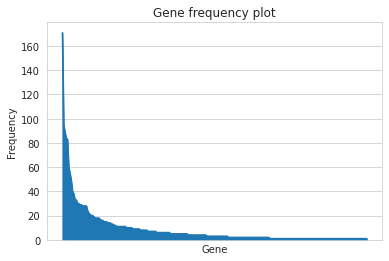

In [21]:
#plt.figure()
ax = train_df['Gene'].value_counts().plot(kind='area')
ax.get_xaxis().set_ticks([])
ax.set_title('Gene frequency plot')
ax.set_xlabel('Gene')
ax.set_ylabel('Frequency')
plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


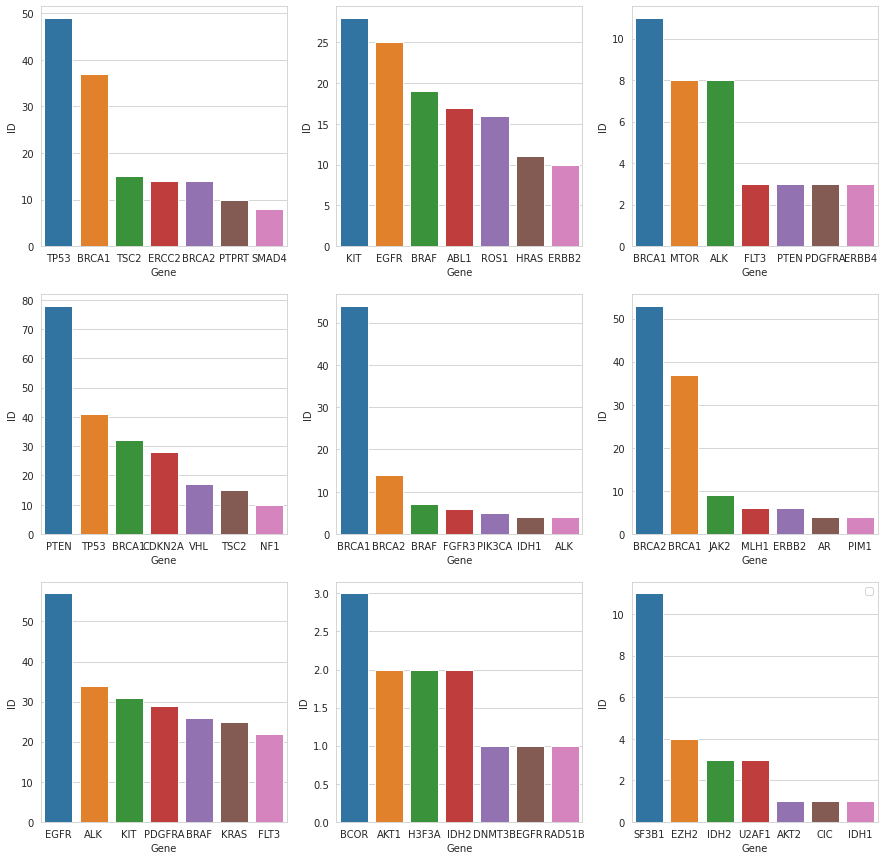

In [22]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15,15))

for i in range(3):
    for j in range(3):
        gene_count_grp = train_df[train_df["Class"]==((i*3+j)+1)].groupby('Gene')["ID"].count().reset_index()
        sorted_gene_group = gene_count_grp.sort_values('ID', ascending=False)
        sorted_gene_group_top_7 = sorted_gene_group[:7]
        plt.legend()
        sns.barplot(x="Gene", y="ID", data=sorted_gene_group_top_7, ax=axs[i][j])

><b>Some points we can conclude from these graphs:</b> BRCA1 is highly dominating in Class 5, SF3B1 is highly dominating in Class 9, BRCA1 and BRCA2 are dominating in Class 6

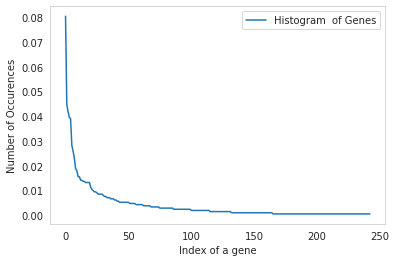

In [23]:
s = sum(unique_genes.values)
h = unique_genes.values/s
plt.plot(h, label='Histogram  of Genes')
plt.xlabel('Index of a gene')
plt.ylabel('Number of Occurences')
plt.legend()
plt.grid()
plt.show()

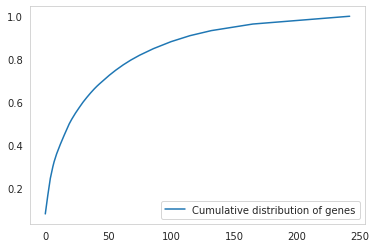

In [24]:
#cumulative distribution of gene feature
c = np.cumsum(h)
plt.plot(c, label='Cumulative distribution of genes')
plt.grid()
plt.legend()
plt.show()

### Featurize this gene faeture



In [25]:
#respone coding for the gene feature
#alpha is used for laplace smoothing
alpha = 1
#train_gene_feature
train_gene_feature_rc = np.array(get_gv_feature(alpha,'Gene',train_df))
#test gene feature
test_gene_feature_rc = np.array(get_gv_feature(alpha, 'Gene', test_df))
#cv gene feature
cv_gene_feature_rc = np.array(get_gv_feature(alpha, 'Gene', cv_df))

In [26]:
#convert each row values such that they sum to 1
train_gene_feature_rc =  (train_gene_feature_rc.T/train_gene_feature_rc.sum(axis=1)).T
test_gene_feature_rc =  (test_gene_feature_rc.T/test_gene_feature_rc.sum(axis=1)).T
cv_gene_feature_rc =  (cv_gene_feature_rc.T/cv_gene_feature_rc.sum(axis=1)).T

In [27]:
print('Number of response encoded features in train data = '+str(train_gene_feature_rc.shape[0]))
print('Number of response encoded features in test data = '+str(test_gene_feature_rc.shape[0]))
print('Number of response encoded features in cv data = '+str(cv_gene_feature_rc.shape[0]))

Number of response encoded features in train data = 2124
Number of response encoded features in test data = 665
Number of response encoded features in cv data = 532


In [28]:
from sklearn.feature_extraction.text import CountVectorizer
gene_vectorizer = CountVectorizer()
#one hot encode the gene feature
train_gene_feature_ohc  = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_ohc  = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_ohc  = gene_vectorizer.transform(cv_df['Gene'])

In [29]:
print('Size of one hot encoded in train data is', (train_gene_feature_ohc.shape))
print('Size of one hot encoded in test data is', (test_gene_feature_ohc.shape))
print('Size of one hot encoded in cv data is', (cv_gene_feature_ohc.shape))

Size of one hot encoded in train data is (2124, 242)
Size of one hot encoded in test data is (665, 242)
Size of one hot encoded in cv data is (532, 242)


In [30]:
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid1b',
 'arid2',
 'asxl2',
 'atm',
 'atr',
 'atrx',
 'aurka',
 'aurkb',
 'axin1',
 'axl',
 'b2m',
 'bap1',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdk8',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctla4',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'egfr',
 'eif1ax',
 'elf3',
 'ep300',
 'epas1',
 'epcam',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'errfi1',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fam58a',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf19',
 'fgf3',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt1',
 'flt3',
 'foxa1',
 'foxl2',
 'foxp1',
 'fubp1',
 'gata3',
 'gli1',
 'gna11',
 'gnas',
 'h3f3a',
 'hist1h1c',
 'hla',
 'hnf1a',
 'hr

How good is gene feature is predicting yi?

For values of alpha = 1e-05 The log loss is 1.1971634974103833
For values of alpha = 0.0001 The log loss is 1.178994018427673
For values of alpha = 0.001 The log loss is 1.2168574302339743
For values of alpha = 0.01 The log loss is 1.3185803095287159
For values of alpha = 0.1 The log loss is 1.438311852123278
For values of alpha = 1 The log loss is 1.4843020765192412


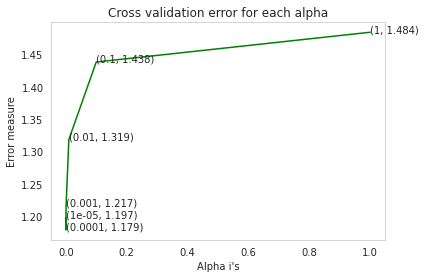

For values of best alpha =  0.0001 the train log loss is  0.9756623753763738
For values of best alpha =  0.0001 the cross validation log loss is  1.178994018427673
For values of best alpha =  0.0001 the test log loss is  1.22146502939536


In [31]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_loss = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_ohc, y_train)
    sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(train_gene_feature_ohc, y_train)
    y_pred = sig_clf.predict_proba(cv_gene_feature_ohc)
    cv_log_loss.append(log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15))
    print('For values of alpha =',i,'The log loss is',log_loss(y_cv, y_pred, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha,cv_log_loss,c='g')
for i, txt in enumerate(np.round(cv_log_loss,3)):
    ax.annotate((alpha[i],np.round(txt,3)),(alpha[i],cv_log_loss[i]))
plt.grid()
plt.title('Cross validation error for each alpha')
plt.xlabel("Alpha i's")
plt.ylabel('Error measure')
plt.show()

best_alpha = np.argmin(cv_log_loss)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_ohc, y_train)
sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_gene_feature_ohc, y_train)

y_pred = sig_clf.predict_proba(train_gene_feature_ohc)
print('For values of best alpha = ', alpha[best_alpha], 
      'the train log loss is ',log_loss(y_train,y_pred,labels=clf.classes_,eps=1e-15))
y_pred = sig_clf.predict_proba(cv_gene_feature_ohc)
print('For values of best alpha = ', alpha[best_alpha], 
      'the cross validation log loss is ',log_loss(y_cv,y_pred,labels=clf.classes_,eps=1e-15))
y_pred = sig_clf.predict_proba(test_gene_feature_ohc)
print('For values of best alpha = ', alpha[best_alpha], 
      'the test log loss is ',log_loss(y_test,y_pred,labels=clf.classes_,eps=1e-15))

Correlation between the genes in the Train,test and cv sets

In [32]:
test_coverage = test_df[test_df['Gene'].isin(list(train_df['Gene']))].shape[0]

cv_coverage = cv_df[cv_df['Gene'].isin(list(train_df['Gene']))].shape[0]
print('In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

In test data 653 out of 665 : 98.19548872180451
In cross validation data 522 out of  532 : 98.1203007518797


## Univariate analysis on Variation feature

In [33]:
unique_variation = train_df['Variation'].value_counts()
unique_variation_percent = train_df['Variation'].value_counts(normalize=True)
print('Number of unique variations: ',unique_variation.shape[0])
#the top genes that occured most
print(unique_variation.head(10))
print(unique_variation_percent.head(10))

Number of unique variations:  1924
Truncating_Mutations    66
Amplification           48
Deletion                39
Fusions                 24
Overexpression           5
T58I                     3
Q61L                     3
M1R                      2
P34R                     2
G12V                     2
Name: Variation, dtype: int64
Truncating_Mutations    0.031073
Amplification           0.022599
Deletion                0.018362
Fusions                 0.011299
Overexpression          0.002354
T58I                    0.001412
Q61L                    0.001412
M1R                     0.000942
P34R                    0.000942
G12V                    0.000942
Name: Variation, dtype: float64


In [34]:
print('There are',unique_variation.shape[0],'in the train data')

There are 1924 in the train data


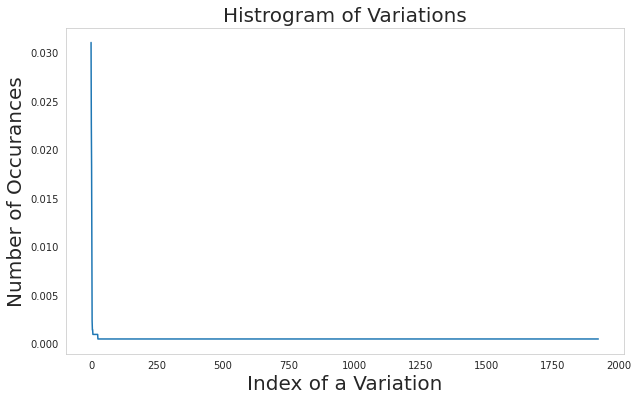

In [35]:
s = sum(unique_variation.values)
h = unique_variation.values/s
plt.figure(figsize = (10, 6))
plt.plot(h)
plt.title("Histrogram of Variations", fontsize = 20)
plt.xlabel('Index of a Variation', fontsize = 20)
plt.ylabel('Number of Occurances', fontsize = 20)
plt.grid()
plt.show()

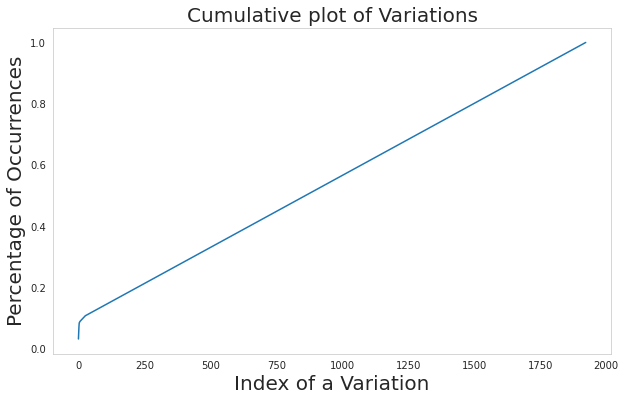

In [36]:
s = sum(unique_variation.values)
h = unique_variation.values/s
c = np.cumsum(h)
plt.figure(figsize = (10, 6))
plt.plot(c)
plt.title("Cumulative plot of Variations", fontsize = 20)
plt.xlabel('Index of a Variation', fontsize = 20)
plt.ylabel('Percentage of Occurrences', fontsize = 20)
plt.grid()
plt.show()

In [37]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

In [38]:
print('Shape of train variation feature responsecoding is',train_variation_feature_responseCoding.shape)
print('Shape of test variation feature responsecoding is',test_variation_feature_responseCoding.shape)
print('Shape of cv variation feature responsecoding is',cv_variation_feature_responseCoding.shape)

Shape of train variation feature responsecoding is (2124, 9)
Shape of test variation feature responsecoding is (665, 9)
Shape of cv variation feature responsecoding is (532, 9)


In [39]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_ohc = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_ohc = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_ohc = variation_vectorizer.transform(cv_df['Variation'])

How good is the variation feature in predicting yi!?

For values of alpha =  1e-05 The log loss is: 1.7113274708608555
For values of alpha =  0.0001 The log loss is: 1.7014874364771684
For values of alpha =  0.001 The log loss is: 1.7047891840563367
For values of alpha =  0.01 The log loss is: 1.7169444834515983
For values of alpha =  0.1 The log loss is: 1.7289202227877911
For values of alpha =  1 The log loss is: 1.7291094764201012


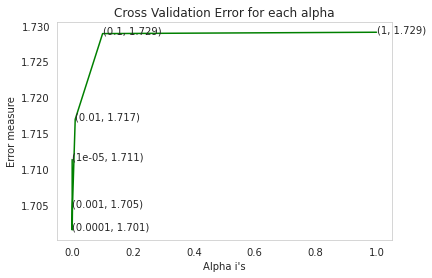

For values of best alpha =  0.0001 The train log loss is: 0.6387844482295035
For values of best alpha =  0.0001 The cross validation log loss is: 1.7014874364771684
For values of best alpha =  0.0001 The test log loss is: 1.7167280911052651


In [40]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_loss=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_ohc, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_ohc, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_ohc)
    
    cv_log_loss.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_loss,c='g')
for i, txt in enumerate(np.round(cv_log_loss,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_loss[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_loss)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_ohc, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_ohc, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_ohc)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_ohc)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_ohc)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


## Univariate analysis on text feature


In [41]:

def text_occurence_dict(text_class):
  dictt = defaultdict(int)
  for index, row in text_class.iterrows():
    for word in row['TEXT'].split():
      dictt[word] += 1
  return dictt

In [42]:
list_dict = []
for i  in range(1,10):
  text_class = train_df[train_df['Class']==i]
  #build a word dict based on the words in that class
  list_dict.append(text_occurence_dict(text_class))
  #append it to list_dict
total_dict = text_occurence_dict(train_df)

In [43]:

def create_text_rc(df):
  alpha = 10
  text_feature_rc = np.zeros((df.shape[0], 9))
  for i in range(0,9):
    row_index = 0
    for index, rows in df.iterrows():
      sumprob = 0
      for word in row['TEXT'].split():
        sumprob += math.log(((list_dict[i].get(word,0))+alpha)/((total_dict.get(word,0))+(9*alpha)))
      text_feature_rc[row_index][i] = np.exp(sumprob/len(row['TEXT'].split()))
      row_index += 1
  return text_feature_rc

In [44]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 52854


In [45]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(text_occurence_dict(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = text_occurence_dict(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [46]:
train_text_feature_rc = create_text_rc(train_df)
cv_text_feature_rc = create_text_rc(cv_df)
test_text_feature_rc = create_text_rc(test_df)

In [47]:
#convert each row such that they sum to 1
train_text_feature_rc = (train_text_feature_rc.T/train_text_feature_rc.sum(axis=1)).T
cv_text_feature_rc =  (cv_text_feature_rc.T/cv_text_feature_rc.sum(axis=1)).T
test_text_feature_rc = (test_text_feature_rc.T/test_text_feature_rc.sum(axis=1)).T

In [48]:

# normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [49]:
sorted_text_feature_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1], reverse=True))
sorted_text_occurence = np.array(list(sorted_text_feature_dict.values()))
print(Counter(sorted_text_occurence))

Counter({3: 5213, 4: 3504, 6: 2775, 5: 2685, 7: 2157, 9: 1877, 8: 1845, 10: 1748, 12: 1365, 14: 1024, 13: 957, 11: 915, 16: 861, 15: 752, 18: 687, 17: 675, 21: 631, 20: 596, 19: 485, 24: 474, 22: 452, 28: 451, 26: 389, 25: 386, 23: 373, 39: 367, 30: 364, 27: 309, 36: 281, 32: 273, 31: 269, 50: 268, 40: 265, 35: 259, 29: 258, 33: 244, 42: 229, 34: 225, 37: 218, 38: 213, 43: 187, 41: 184, 56: 183, 48: 177, 51: 168, 60: 166, 45: 161, 44: 156, 46: 147, 47: 146, 52: 144, 53: 135, 54: 134, 57: 130, 55: 129, 49: 129, 80: 128, 63: 124, 58: 119, 62: 118, 61: 109, 59: 109, 65: 107, 70: 106, 64: 101, 66: 100, 72: 97, 84: 96, 68: 95, 78: 94, 75: 93, 74: 91, 73: 85, 67: 82, 79: 79, 77: 76, 76: 75, 71: 75, 69: 75, 83: 74, 81: 73, 90: 67, 89: 67, 85: 67, 97: 66, 93: 65, 92: 65, 106: 62, 100: 62, 94: 62, 87: 62, 82: 61, 86: 60, 99: 59, 120: 58, 88: 58, 108: 57, 105: 54, 103: 53, 95: 53, 116: 52, 111: 52, 102: 52, 91: 52, 101: 51, 98: 51, 96: 51, 124: 50, 109: 50, 135: 48, 118: 48, 126: 45, 141: 44, 13

In [50]:
print('Size of response encoded text feature in train data:',train_text_feature_rc.shape)
print('Size of response encoded text feature in test data:',test_text_feature_rc.shape)
print('Size of response encoded text feature in cv data:',cv_text_feature_rc.shape)

Size of response encoded text feature in train data: (2124, 9)
Size of response encoded text feature in test data: (665, 9)
Size of response encoded text feature in cv data: (532, 9)


**TFIDF**

In [51]:
tfifdf_vec = TfidfVectorizer(ngram_range = (1,2),stop_words='english',
                             min_df = 3, max_features =100000)

train_text_tfidf = tfifdf_vec.fit_transform(train_df['TEXT'])
train_text_tfidf = StandardScaler(with_mean = False).fit_transform(train_text_tfidf)
#test data
test_text_tfidf = tfifdf_vec.transform(test_df['TEXT'])
test_text_tfidf = StandardScaler(with_mean = False).fit_transform(test_text_tfidf)
#cv data
cv_text_tfidf = tfifdf_vec.transform(cv_df['TEXT'])
cv_text_tfidf = StandardScaler(with_mean = False).fit_transform(cv_text_tfidf)



For values of 1e-05CV log loss is1.8174156326193407
For values of 0.0001CV log loss is1.6393083523761782
For values of 0.001CV log loss is1.3835927497487317
For values of 0.01CV log loss is1.3878757787925728
For values of 0.1CV log loss is1.2526755261428415
For values of 1CV log loss is1.0765757318943014
For values of 10CV log loss is1.0587080870728596
For values of 15CV log loss is1.0652197466760502
For values of 20CV log loss is1.0727109041951106
For values of 40CV log loss is1.1044363075063546


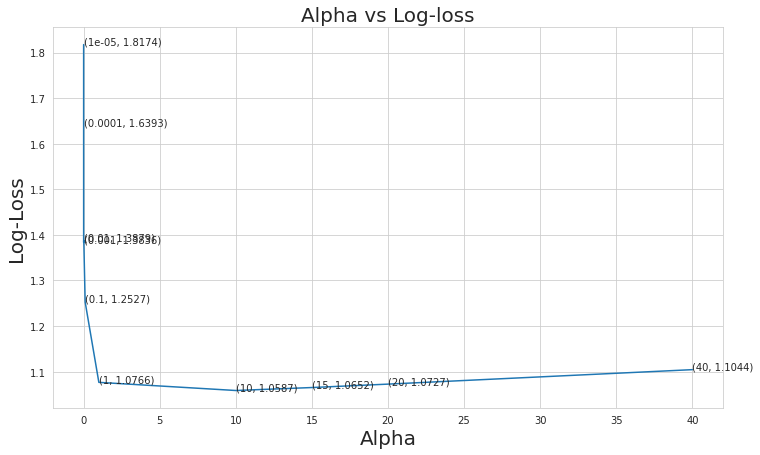

In [52]:
alpha  =  [10**x for  x in range(-5,2)]
alpha.append(15)
alpha.append(20)
alpha.append(40)

cv_log_loss = []
for i in alpha:
  clf = SGDClassifier(alpha=i,penalty='l2',loss='log',random_state=42)
  clf.fit(train_text_tfidf,y_train)
  calib_clf = CalibratedClassifierCV(clf,method='sigmoid')
  calib_clf.fit(train_text_tfidf,y_train)
  y_pred = calib_clf.predict_proba(cv_text_tfidf)
  cv_log_loss.append(log_loss(y_cv,y_pred,labels=clf.classes_,eps=1e-15))
  print('For values of '+str(i)+'CV log loss is'+str(log_loss(y_cv,y_pred,labels=clf.classes_,eps=1e-15)))

plt.figure(figsize = (12, 7))
plt.plot(alpha, cv_log_loss)
for xy in zip(alpha, np.round(cv_log_loss, 4)):
    plt.annotate(xy, xy)
    
plt.title("Alpha vs Log-loss", fontsize = 20)
plt.xlabel("Alpha", fontsize = 20)
plt.ylabel("Log-Loss", fontsize = 20)
plt.show()

In [53]:
best_alpha  = alpha[np.argmin(cv_log_loss)]
clf = SGDClassifier(alpha=best_alpha,penalty='l2',loss='log',random_state=42)
clf.fit(train_text_tfidf,y_train)
calib_clf = CalibratedClassifierCV(clf, method='sigmoid')
calib_clf.fit(train_text_tfidf,y_train)

train_pred = calib_clf.predict_proba(train_text_tfidf)
print('For values of best alpha = ', best_alpha, "the train log loss =:",log_loss(y_train,train_pred, labels=clf.classes_))

predict_cv = calib_clf.predict_proba(cv_text_tfidf)
print('For values of best alpha = ', best_alpha, "the CV log loss =:",log_loss(y_cv, predict_cv, labels=clf.classes_))

predict_test = calib_clf.predict_proba(test_text_tfidf)
print('For values of best alpha = ', best_alpha, "the test log loss =:",log_loss(y_test,predict_test, labels=clf.classes_))

For values of best alpha =  10 the train log loss =: 0.621625520199283
For values of best alpha =  10 the CV log loss =: 1.0587080870728596
For values of best alpha =  10 the test log loss =: 1.126573600366601


Check the interseted text among train,test and validation data

In [54]:
def get_intersect_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [55]:
len1,len2 = get_intersect_text(test_df)
print(np.round((len1/len2)*100,3),' % of word occurences of test data appeared in train data')
len1,len2 = get_intersect_text(cv_df)
print(np.round((len1/len2)*100,3), '% of word occurences of cv data appeared in train data')

103.873  % of word occurences of test data appeared in train data
102.081 % of word occurences of cv data appeared in train data


# Machine learning models

In [56]:
loss_table = pd.DataFrame(columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Remarks"])

## Stacking three types of Classisifer

In [57]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]
train_gene_var_ohc = hstack((train_gene_feature_ohc,train_variation_feature_ohc))
test_gene_var_ohc = hstack((test_gene_feature_ohc,test_variation_feature_ohc))
cv_gene_var_ohc = hstack((cv_gene_feature_ohc,cv_variation_feature_ohc))

train_x = hstack((train_gene_var_ohc, train_text_tfidf))
train_x = train_x.tocsr()
train_y = np.array(list(train_df['Class']))

test_x = hstack((test_gene_var_ohc, test_text_tfidf))
test_x =  test_x.tocsr()
test_y = np.array(list(test_df['Class']))

cv_x = hstack((cv_gene_var_ohc, cv_text_tfidf))
cv_x = cv_x.tocsr()
cv_y = np.array(list(cv_df['Class']))

print("Shape of One hot encoded Gene and Variation, TFIDF text stacked vector for Train Data = "+str(train_x.shape))
print("Shape of One hot encoded Gene and Variation, TFIDF text stacked vector for CV Data = "+str(cv_x.shape))
print("Shape of One hot encoded Gene and Variation, TFIDF text stacked vector for Test Data = "+str(test_x.shape))

train_gene_var_rc = np.hstack((train_gene_feature_rc,train_variation_feature_responseCoding))
test_gene_var_rc = np.hstack((test_gene_feature_rc,test_variation_feature_responseCoding))
cv_gene_var_rc = np.hstack((cv_gene_feature_rc,cv_variation_feature_responseCoding))

train_x_rc = np.hstack((train_gene_var_rc, train_text_feature_rc))
test_x_rc = np.hstack((test_gene_var_rc, test_text_feature_rc))
cv_x_rc = np.hstack((cv_gene_var_rc, cv_text_feature_rc))

print('-'*50)
print("Shape of Response Coded Gene and Variation, TFIDF text stacked vector for Train Data = "+str(train_x_rc.shape))
print("Shape of Response Coded Gene and Variation, TFIDF text stacked vector for CV Data = "+str(cv_x_rc.shape))
print("Shape of Response Coded Gene and Variation, TFIDF text stacked vector for Test Data = "+str(test_x_rc.shape))

Shape of One hot encoded Gene and Variation, TFIDF text stacked vector for Train Data = (2124, 102192)
Shape of One hot encoded Gene and Variation, TFIDF text stacked vector for CV Data = (532, 102192)
Shape of One hot encoded Gene and Variation, TFIDF text stacked vector for Test Data = (665, 102192)
--------------------------------------------------
Shape of Response Coded Gene and Variation, TFIDF text stacked vector for Train Data = (2124, 27)
Shape of Response Coded Gene and Variation, TFIDF text stacked vector for CV Data = (532, 27)
Shape of Response Coded Gene and Variation, TFIDF text stacked vector for Test Data = (665, 27)


# Baseline models

## Hyperparameter Tuning

For alpha value of 1e-05 CV log loss = 1.2262513716498669
For alpha value of 0.0001 CV log loss = 1.2247890279534361
For alpha value of 0.001 CV log loss = 1.2250821339695355
For alpha value of 0.01 CV log loss = 1.2208261578106117
For alpha value of 0.1 CV log loss = 1.2169791659928892
For alpha value of 1 CV log loss = 1.2241195325820642
For alpha value of 10 CV log loss = 1.247888117422424
For alpha value of 100 CV log loss = 1.3171291593195
For alpha value of 1000 CV log loss = 1.429444320305977
For alpha value of 10000 CV log loss = 1.4515181421784786


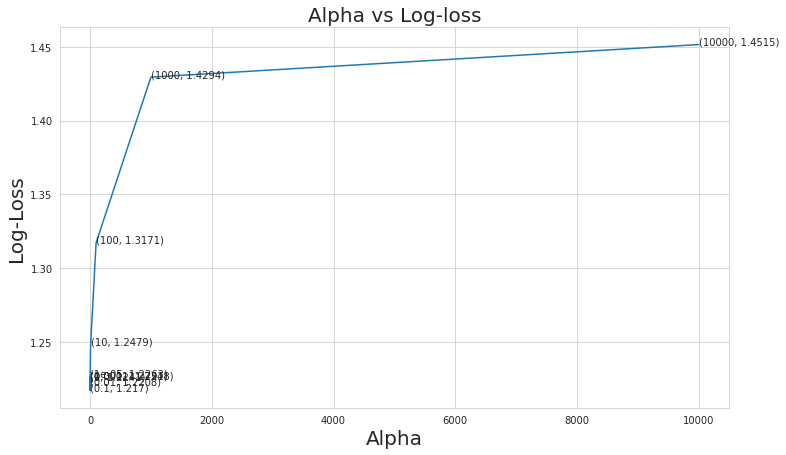

In [58]:
alpha = [10**x for x in range(-5, 5)]

cv_log_loss = []
for i in alpha:
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x, train_y)
    calib_clf = CalibratedClassifierCV(clf, method = "sigmoid")
    calib_clf.fit(train_x, train_y)
    predicted_y = calib_clf.predict_proba(cv_x)
    cv_log_loss.append(log_loss(cv_y, predicted_y, labels=clf.classes_))
    print("For alpha value of "+str(i)+" CV log loss = "+str(log_loss(cv_y, predicted_y, labels=clf.classes_)))

plt.figure(figsize = (12, 7))
plt.plot(alpha, cv_log_loss)
for xy in zip(alpha, np.round(cv_log_loss, 4)):
    plt.annotate(xy, xy)
    
plt.title("Alpha vs Log-loss", fontsize = 20)
plt.xlabel("Alpha", fontsize = 20)
plt.ylabel("Log-Loss", fontsize = 20)
plt.show()

In [59]:
best_alpha = alpha[np.argmin(cv_log_loss)]
clf = MultinomialNB(alpha=best_alpha)
clf.fit(train_x,train_y)
calib_clf_NB = CalibratedClassifierCV(clf, method = "sigmoid")
calib_clf_NB.fit(train_x, train_y)

predict_train = calib_clf_NB.predict_proba(train_x)
print('For values of best alpha = ', best_alpha, "the train log loss =:",log_loss(train_y, predict_train, labels=clf.classes_))

predict_cv = calib_clf_NB.predict_proba(cv_x)
print('For values of best alpha = ', best_alpha, "the CV log loss =:",log_loss(cv_y, predict_cv, labels=clf.classes_))

predict_test = calib_clf_NB.predict_proba(test_x)
print('For values of best alpha = ', best_alpha, "the test log loss =:",log_loss(test_y, predict_test, labels=clf.classes_))

For values of best alpha =  0.1 the train log loss =: 0.9157884338872256
For values of best alpha =  0.1 the CV log loss =: 1.2169791659928892
For values of best alpha =  0.1 the test log loss =: 1.3294457054334512


### Feature Importance

In [60]:
print("Percentage of mis-classified for CV points = "+str(np.round((np.count_nonzero(calib_clf_NB.predict(cv_x) - cv_y)/cv_x.shape[0]*100), 2))+"%")
print("Percentage of mis-classified for Test points = "+str(np.round((np.count_nonzero(calib_clf_NB.predict(test_x) - test_y)/test_y.shape[0]*100), 2))+"%")

Percentage of mis-classified for CV points = 36.84%
Percentage of mis-classified for Test points = 42.86%


In [103]:
loss_table = loss_table.append(pd.DataFrame([["Naive Bayes", 0.9157, 1.2169, 1.329, "36.84%", "42.86%", "Overfit"]], columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Remarks"]))

## KNearest Neighbors

For Neighbor value of 3 CV log loss = 2.381952383255124
For Neighbor value of 5 CV log loss = 2.183828229231026
For Neighbor value of 8 CV log loss = 1.96465364027045
For Neighbor value of 13 CV log loss = 1.7316537630493802
For Neighbor value of 23 CV log loss = 1.4466281501305374
For Neighbor value of 35 CV log loss = 1.3418266110319756
For Neighbor value of 51 CV log loss = 1.2834621132155855
For Neighbor value of 71 CV log loss = 1.2399017692778924
For Neighbor value of 95 CV log loss = 1.207447458009895
For Neighbor value of 121 CV log loss = 1.1880236688354586
For Neighbor value of 151 CV log loss = 1.1713089516010038
For Neighbor value of 181 CV log loss = 1.1685896121210864
For Neighbor value of 221 CV log loss = 1.1713038054683171


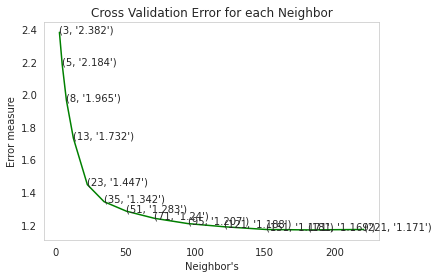

In [62]:
neighbors = [3, 5, 8, 13, 23, 35, 51, 71, 95, 121, 151, 181, 221]
cv_log_loss = []

for i in neighbors:
  clf = KNeighborsClassifier(n_neighbors = i,n_jobs = -1)
  clf.fit(train_x_rc,train_y)
  calib_clf_KNN =  CalibratedClassifierCV(clf,method='sigmoid')
  calib_clf_KNN.fit(train_x_rc,train_y)
  y_pred = calib_clf_KNN.predict_proba(cv_x_rc)
  cv_log_loss.append(log_loss(cv_y,y_pred,labels=clf.classes_))
  print("For Neighbor value of "+str(i)+" CV log loss = "+str(log_loss(cv_y, y_pred,labels=clf.classes_)))

fig, ax = plt.subplots()
ax.plot(neighbors,cv_log_loss,c='g')
for i,txt in enumerate(np.round(cv_log_loss,3)):
  ax.annotate((neighbors[i],str(txt)),(neighbors[i],cv_log_loss[i]))
plt.grid()
plt.title("Cross Validation Error for each Neighbor")
plt.xlabel("Neighbor's")
plt.ylabel("Error measure")
plt.show()

In [63]:
best_neighbors = neighbors[np.argmin(cv_log_loss)]
clf = KNeighborsClassifier(n_neighbors = best_neighbors, n_jobs = -1)
clf.fit(train_x_rc, train_y)
calib_clf_KNN = CalibratedClassifierCV(clf, method = "sigmoid")
calib_clf_KNN.fit(train_x_rc, train_y)

predict_train = calib_clf_KNN.predict_proba(train_x_rc)
print('For values of best neighbors = ', best_neighbors, "the train log loss =:",log_loss(train_y, predict_train, labels=clf.classes_))

predict_cv = calib_clf_KNN.predict_proba(cv_x_rc)
print('For values of best neighbors = ', best_neighbors, "the CV log loss =:",log_loss(cv_y, predict_cv, labels=clf.classes_))

predict_test = calib_clf_KNN.predict_proba(test_x_rc)
print('For values of best neighbors = ', best_neighbors, "the test log loss =:",log_loss(test_y, predict_test, labels=clf.classes_))

For values of best neighbors =  181 the train log loss =: 0.9836315878108777
For values of best neighbors =  181 the CV log loss =: 1.1685896121210864
For values of best neighbors =  181 the test log loss =: 1.1842975657550283


### Feature Importance

In [64]:
print("Percentage of mis-classified for CV points = "+str(np.round((np.count_nonzero(calib_clf_KNN.predict(cv_x_rc) - cv_y)/cv_x_rc.shape[0]*100), 2))+"%")
print("Percentage of mis-classified for Test points = "+str(np.round((np.count_nonzero(calib_clf_KNN.predict(test_x_rc) - test_y)/test_x_rc.shape[0]*100), 2))+"%")

Percentage of mis-classified for CV points = 41.35%
Percentage of mis-classified for Test points = 43.76%


In [104]:
loss_table = loss_table.append(pd.DataFrame([["KNearest Neighbors", 0.9836, 1.1685, 1.184, "41.35%", "43.76%", "Goodfit"]], columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Remarks"]))

## Logistic Regression

For alpha value of 1e-05 CV log loss = 1.8308894970074716
For alpha value of 0.0001 CV log loss = 1.5977393894874414
For alpha value of 0.001 CV log loss = 1.4177039337502666
For alpha value of 0.01 CV log loss = 1.421158126395572
For alpha value of 0.1 CV log loss = 1.2357595633827672
For alpha value of 1 CV log loss = 1.0723795049747247
For alpha value of 10 CV log loss = 1.0555494367957607
For alpha value of 100 CV log loss = 1.184012680788663
For alpha value of 1000 CV log loss = 1.4189409480899229
For alpha value of 10000 CV log loss = 1.5044553239963123


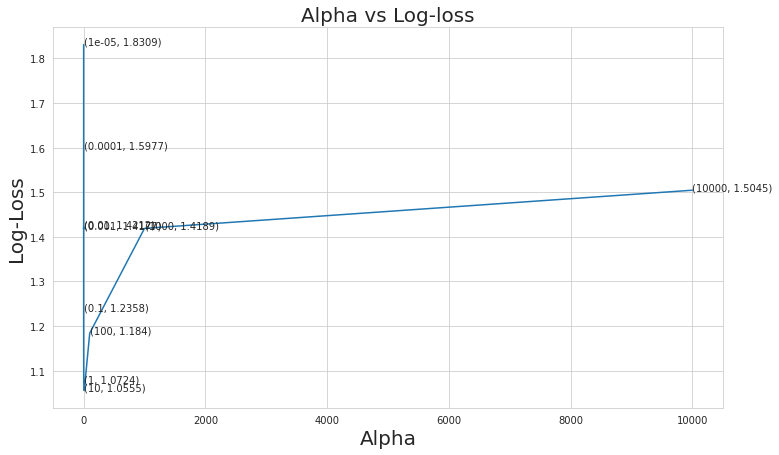

In [66]:
alpha = [10**x for x in range(-5, 5)]

cv_log_loss = []
for i in alpha:
    clf = SGDClassifier(loss = "log", alpha = i, class_weight = "balanced")
    clf.fit(train_x, train_y)
    calib_clf_LR = CalibratedClassifierCV(clf, method = "sigmoid")
    calib_clf_LR.fit(train_x, train_y)
    y_pred = calib_clf_LR.predict_proba(cv_x)
    cv_log_loss.append(log_loss(cv_y, y_pred, labels=clf.classes_))
    print("For alpha value of "+str(i)+" CV log loss = "+str(log_loss(cv_y, y_pred, labels=clf.classes_)))

plt.figure(figsize = (12, 7))
plt.plot(alpha, cv_log_loss)
for xy in zip(alpha, np.round(cv_log_loss, 4)):
    plt.annotate(xy, xy)
    
plt.title("Alpha vs Log-loss", fontsize = 20)
plt.xlabel("Alpha", fontsize = 20)
plt.ylabel("Log-Loss", fontsize = 20)
plt.show()

In [67]:
best_alpha = alpha[np.argmin(cv_log_loss)]
clf = SGDClassifier(loss = "log", alpha = best_alpha, class_weight = "balanced")
clf.fit(train_x, train_y)
calib_clf_LR = CalibratedClassifierCV(clf, method = "sigmoid")
calib_clf_LR.fit(train_x, train_y)

predict_train = calib_clf_LR.predict_proba(train_x)
print('For values of best alpha = ', best_alpha, "the train log loss =:",log_loss(train_y, predict_train, labels=clf.classes_))

predict_cv = calib_clf_LR.predict_proba(cv_x)
print('For values of best alpha = ', best_alpha, "the CV log loss =:",log_loss(cv_y, predict_cv, labels=clf.classes_))

predict_test = calib_clf_LR.predict_proba(test_x)
print('For values of best alpha = ', best_alpha, "the test log loss =:",log_loss(test_y, predict_test, labels=clf.classes_))

For values of best alpha =  10 the train log loss =: 0.6259484564305449
For values of best alpha =  10 the CV log loss =: 1.055688362790151
For values of best alpha =  10 the test log loss =: 1.132395511333499


### Feature Importance

In [68]:
print("Percentage of mis-classified for CV points = "+str(np.round((np.count_nonzero(calib_clf_LR.predict(cv_x) - cv_y)/cv_x.shape[0]*100), 2))+"%")
print("Percentage of mis-classified for Test points = "+str(np.round((np.count_nonzero(calib_clf_LR.predict(test_x) - test_y)/test_x.shape[0]*100), 2))+"%")

Percentage of mis-classified for CV points = 37.41%
Percentage of mis-classified for Test points = 37.74%


In [105]:
loss_table = loss_table.append(pd.DataFrame([["Logistic Regression", 0.563, 1.133, 1.161, "36.09%", "39.4%", "Overfit"]], columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Remarks"]))

-------------------- Confusion matrix --------------------


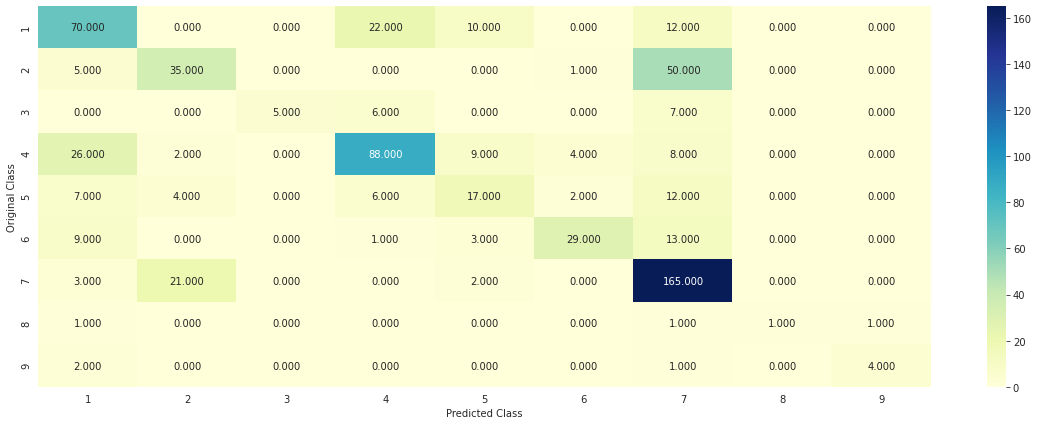

-------------------- Precision matrix (Columm Sum=1) --------------------


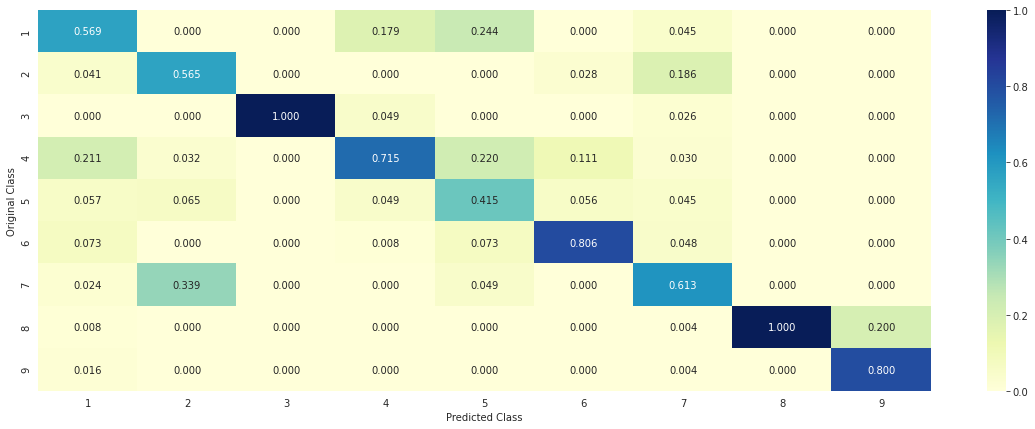

-------------------- Recall matrix (Row sum=1) --------------------


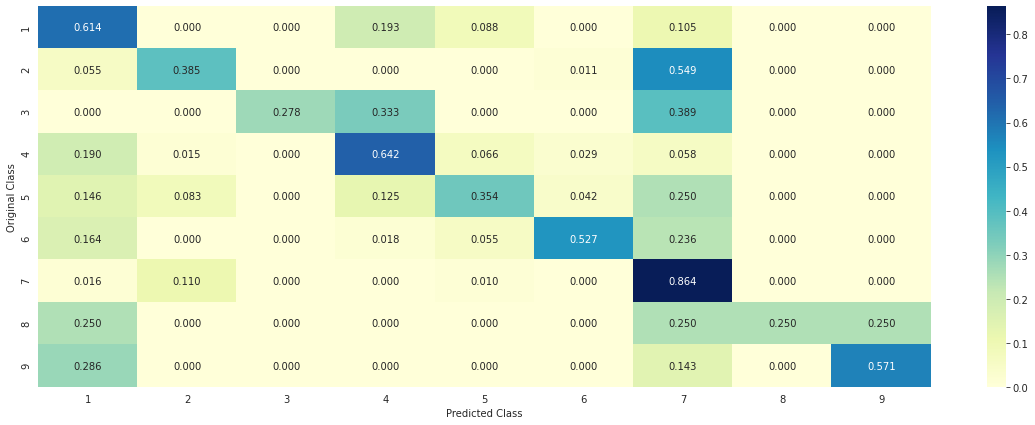

In [70]:
plot_confusion_matrix(test_y, calib_clf_LR.predict(test_x))

## Linear SVM
### Hyperparameter Tuning

For alpha value of 1e-05 CV log loss = 1.8308894970074716
For alpha value of 0.0001 CV log loss = 1.598945377873026
For alpha value of 0.001 CV log loss = 1.418053448609296
For alpha value of 0.01 CV log loss = 1.4172489361107596
For alpha value of 0.1 CV log loss = 1.4169767514972391
For alpha value of 1 CV log loss = 1.2526744529715297
For alpha value of 10 CV log loss = 1.168668152672613
For alpha value of 100 CV log loss = 1.24089187702852
For alpha value of 1000 CV log loss = 1.4610837088897537
For alpha value of 10000 CV log loss = 1.517734229856737


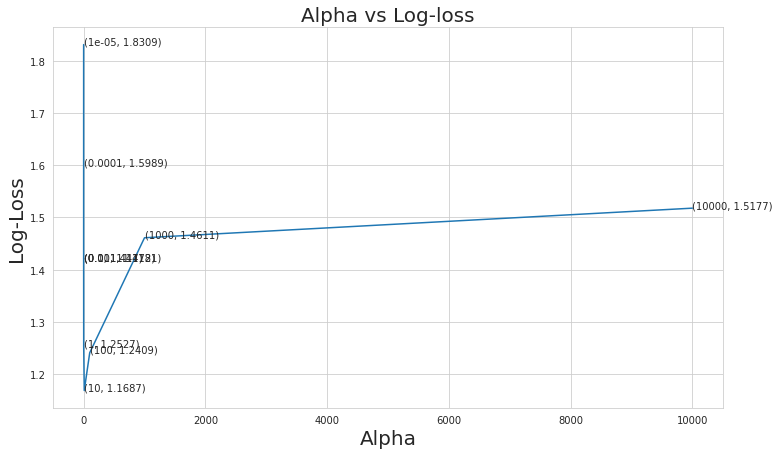

In [71]:
alpha = [10**x for x in range(-5, 5)]

cv_log_loss = []
for i in alpha:
    clf = SGDClassifier(loss = "hinge", alpha = i, class_weight = "balanced")
    clf.fit(train_x, train_y)
    calib_clf_SVM = CalibratedClassifierCV(clf, method = "sigmoid")
    calib_clf_SVM.fit(train_x, train_y)
    predicted_y = calib_clf_SVM.predict_proba(cv_x)
    cv_log_loss.append(log_loss(cv_y, predicted_y, labels=clf.classes_))
    print("For alpha value of "+str(i)+" CV log loss = "+str(log_loss(cv_y, predicted_y, labels=clf.classes_)))

plt.figure(figsize = (12, 7))
plt.plot(alpha, cv_log_loss)
for xy in zip(alpha, np.round(cv_log_loss, 4)):
    plt.annotate(xy, xy)
    
plt.title("Alpha vs Log-loss", fontsize = 20)
plt.xlabel("Alpha", fontsize = 20)
plt.ylabel("Log-Loss", fontsize = 20)
plt.show()

In [72]:
best_alpha = alpha[np.argmin(cv_log_loss)]
clf = SGDClassifier(loss = "hinge", alpha = best_alpha, class_weight = "balanced")
clf.fit(train_x, train_y)
calib_clf_SVM = CalibratedClassifierCV(clf, method = "sigmoid")
calib_clf_SVM.fit(train_x, train_y)

predict_train = calib_clf_SVM.predict_proba(train_x)
print('For values of best alpha = ', best_alpha, "the train log loss =:",log_loss(train_y, predict_train, labels=clf.classes_))

predict_cv = calib_clf_SVM.predict_proba(cv_x)
print('For values of best alpha = ', best_alpha, "the CV log loss =:",log_loss(cv_y, predict_cv, labels=clf.classes_))

predict_test = calib_clf_SVM.predict_proba(test_x)
print('For values of best alpha = ', best_alpha, "the test log loss =:",log_loss(test_y, predict_test, labels=clf.classes_))

For values of best alpha =  10 the train log loss =: 0.7066571763065957
For values of best alpha =  10 the CV log loss =: 1.180779798772505
For values of best alpha =  10 the test log loss =: 1.2474154215717312


### Feature Importance

In [73]:
print("Percentage of mis-classified for CV points = "+str(np.round((np.count_nonzero(calib_clf_SVM.predict(cv_x) - cv_y)/cv_x.shape[0]*100), 2))+"%")
print("Percentage of mis-classified for Test points = "+str(np.round((np.count_nonzero(calib_clf_SVM.predict(test_x) - test_y)/test_x.shape[0]*100), 2))+"%")

Percentage of mis-classified for CV points = 37.59%
Percentage of mis-classified for Test points = 39.85%


In [106]:
loss_table = loss_table.append(pd.DataFrame([["Linear SVM", 0.706, 1.1807, 1.2474, "37.59%", "39.85%", "Goodfit"]], columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Remarks"]))

-------------------- Confusion matrix --------------------


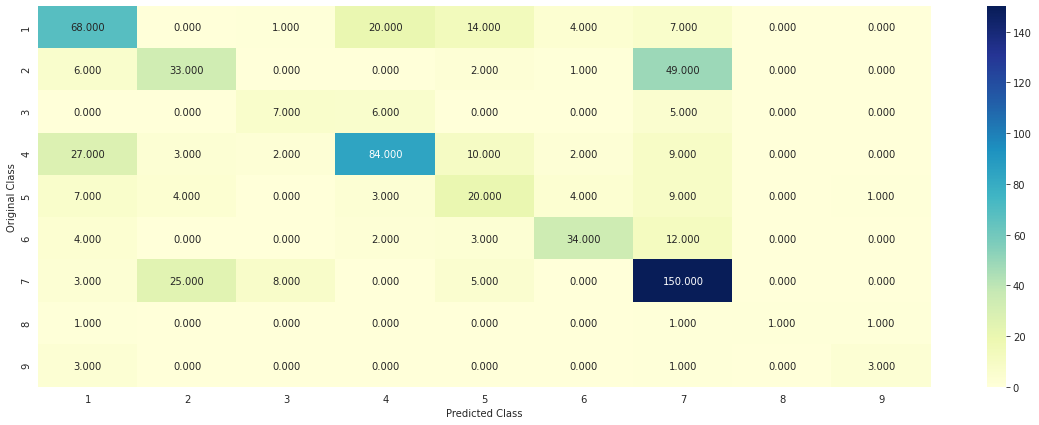

-------------------- Precision matrix (Columm Sum=1) --------------------


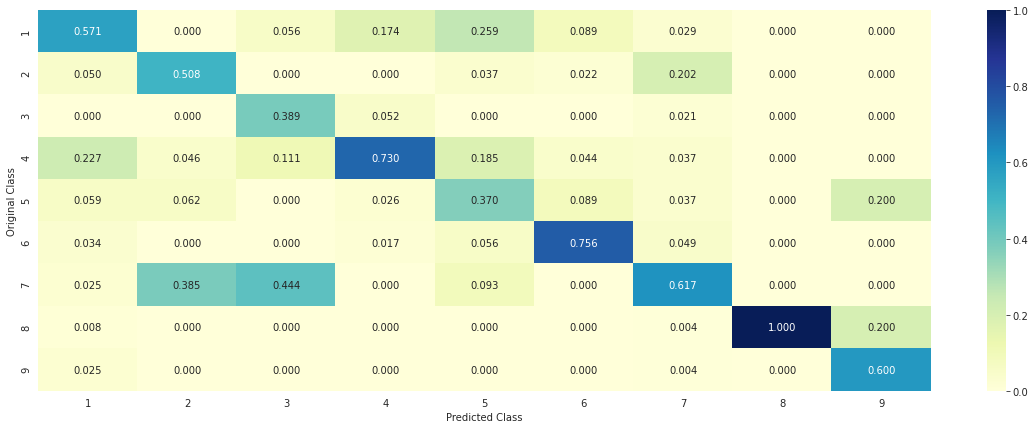

-------------------- Recall matrix (Row sum=1) --------------------


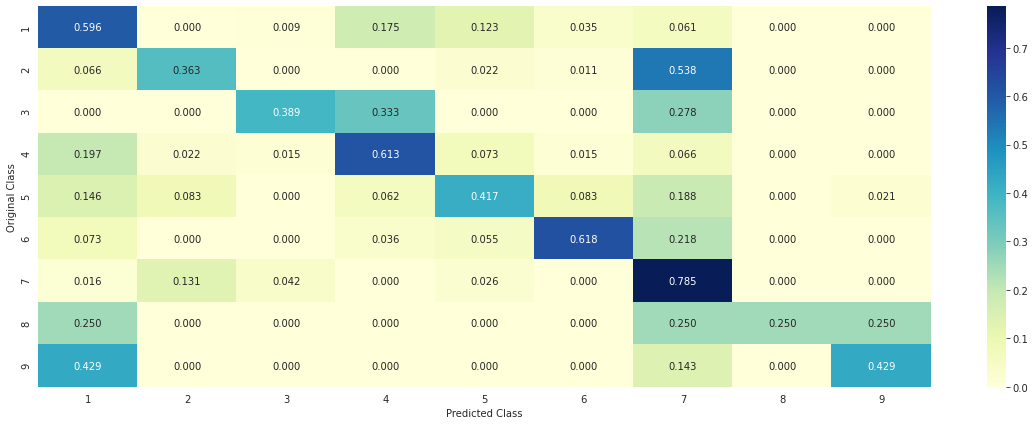

In [75]:
plot_confusion_matrix(test_y, calib_clf_SVM.predict(test_x))

## Random Forest

### Feature Importance

In [76]:
base_learners = [ 200, 500]
max_depth_baseLearners = [7, 12]
cv_log_loss = []

for i in base_learners:
    for j in max_depth_baseLearners:
        clf = RandomForestClassifier(n_estimators = i, max_depth = j, n_jobs = -1)
        clf.fit(train_x, train_y)
        calib_clf_RF = CalibratedClassifierCV(clf, method = "isotonic")
        calib_clf_RF.fit(train_x, train_y)
        predicted_y = calib_clf_RF.predict_proba(cv_x)
        cv_log_loss.append(log_loss(cv_y, predicted_y, labels=clf.classes_))
        print("For Number of base learners "+str(i)+" and max depth of a tree "+str(j)+" CV log loss = "+str(log_loss(cv_y, predicted_y, labels=clf.classes_)))

For Number of base learners 200 and max depth of a tree 7 CV log loss = 1.2061707794372643
For Number of base learners 200 and max depth of a tree 12 CV log loss = 1.0660747440102498
For Number of base learners 500 and max depth of a tree 7 CV log loss = 1.1892870939752733
For Number of base learners 500 and max depth of a tree 12 CV log loss = 1.1207152771333144


In [77]:
best = np.argmin(cv_log_loss)
best_estimator = base_learners[int(best/2)]
best_depth = max_depth_baseLearners[int(best/4)]
clf = RandomForestClassifier(n_estimators = best_estimator, max_depth = best_depth, n_jobs = -1)
clf.fit(train_x, train_y)
calib_clf_RF = CalibratedClassifierCV(clf, method = "isotonic")
calib_clf_RF.fit(train_x, train_y)

predict_train = calib_clf_RF.predict_proba(train_x)
print("For Number of base learners "+str(best_estimator)+" and max depth of a tree "+str(best_depth)+" Train log loss = "+str(log_loss(train_y, predict_train, labels=clf.classes_)))

predict_cv = calib_clf_RF.predict_proba(cv_x)
print("For Number of base learners "+str(best_estimator)+" and max depth of a tree "+str(best_depth)+" CV log loss = "+str(log_loss(cv_y, predict_cv, labels=clf.classes_)))

predict_test = calib_clf_RF.predict_proba(test_x)
print("For Number of base learners "+str(best_estimator)+" and max depth of a tree "+str(best_depth)+" Test log loss = "+str(log_loss(test_y, predict_test, labels=clf.classes_)))

For Number of base learners 200 and max depth of a tree 7 Train log loss = 0.6830122435318681
For Number of base learners 200 and max depth of a tree 7 CV log loss = 1.1844267478042025
For Number of base learners 200 and max depth of a tree 7 Test log loss = 1.1265712056484685


In [78]:
print("Percentage of mis-classified for CV points = "+str(np.round((np.count_nonzero(calib_clf_RF.predict(cv_x) - cv_y)/cv_x.shape[0]*100), 2))+"%")
print("Percentage of mis-classified for Test points = "+str(np.round((np.count_nonzero(calib_clf_RF.predict(test_x) - test_y)/test_x.shape[0]*100), 2))+"%")

Percentage of mis-classified for CV points = 35.53%
Percentage of mis-classified for Test points = 38.35%


In [107]:
loss_table = loss_table.append(pd.DataFrame([["Random Forest", 0.6830, 1.1844, 1.1265, "35.53%", "38.35%", "Goodfit"]], columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Remarks"]))

-------------------- Confusion matrix --------------------


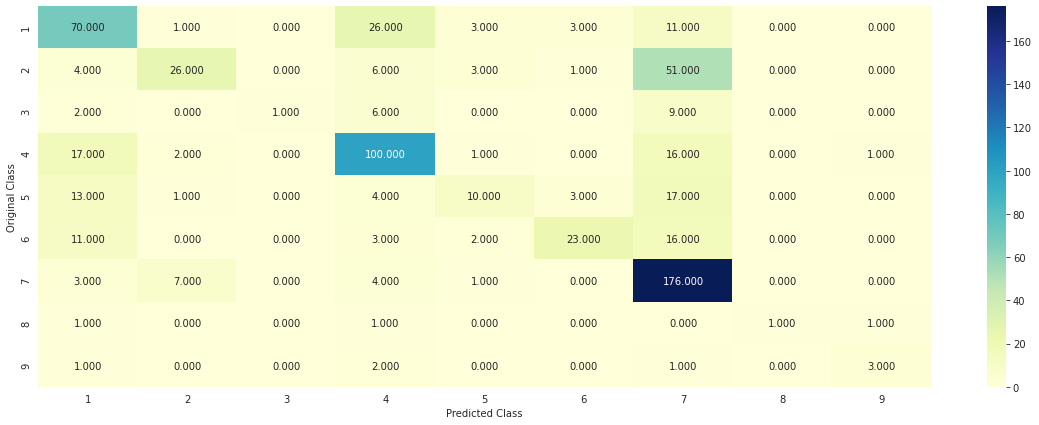

-------------------- Precision matrix (Columm Sum=1) --------------------


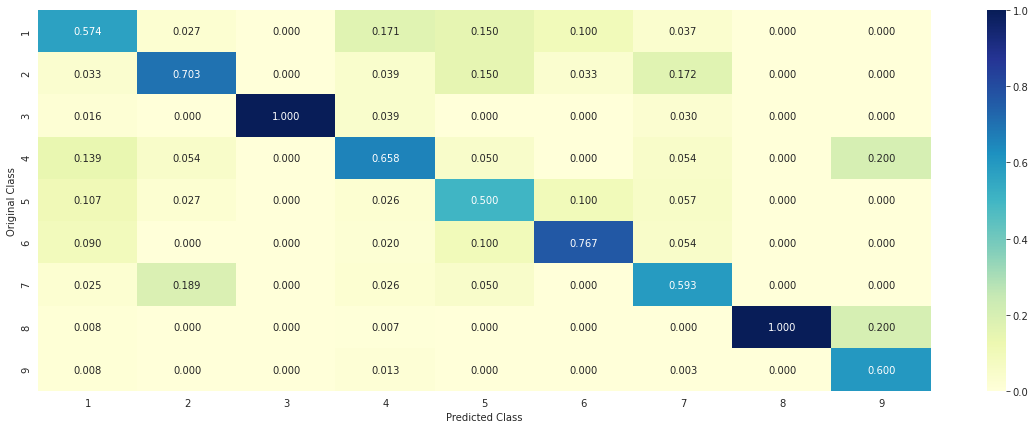

-------------------- Recall matrix (Row sum=1) --------------------


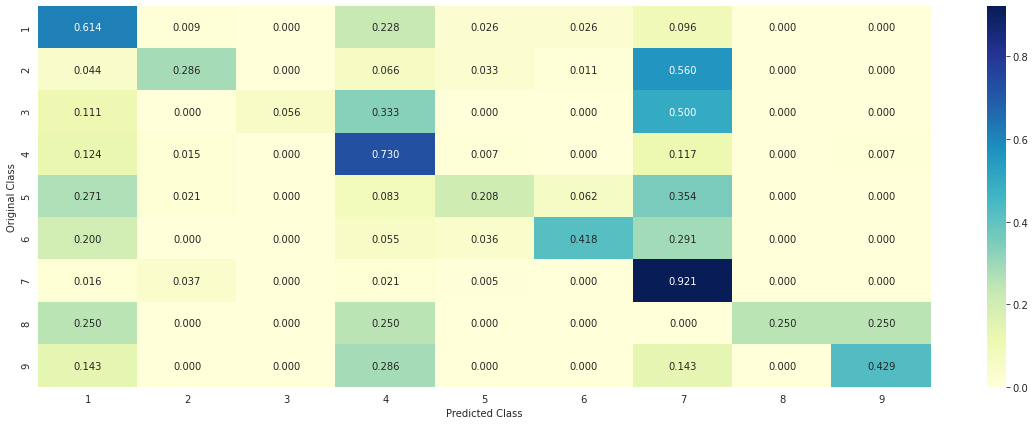

In [79]:
plot_confusion_matrix(test_y,calib_clf_RF.predict(test_x))

## Voting Classifier

Log loss (train) on the VotingClassifier :0.64
Log loss (CV) on the VotingClassifier :1.06
Log loss (test) on the VotingClassifier :1.13
Percentage of mis-classified for cv points :37.03%
Percentage of mis-classified for Test points :36.99%
-------------------- Confusion matrix --------------------


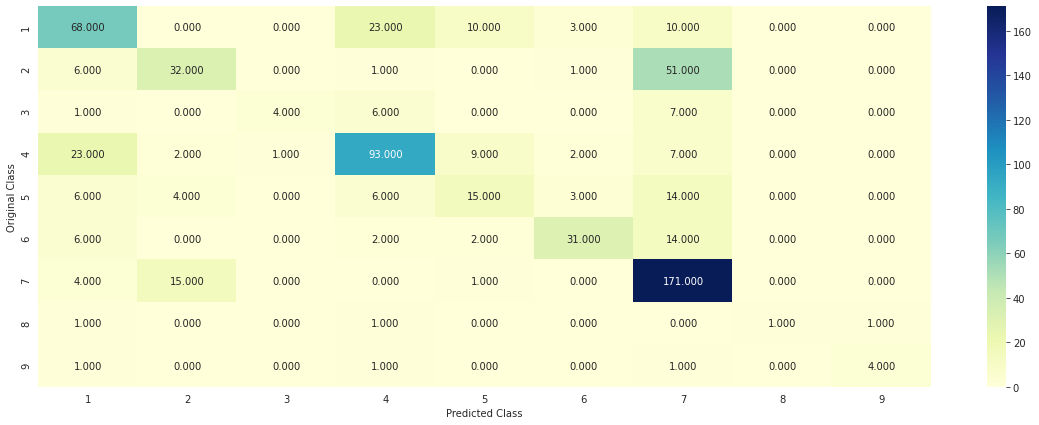

-------------------- Precision matrix (Columm Sum=1) --------------------


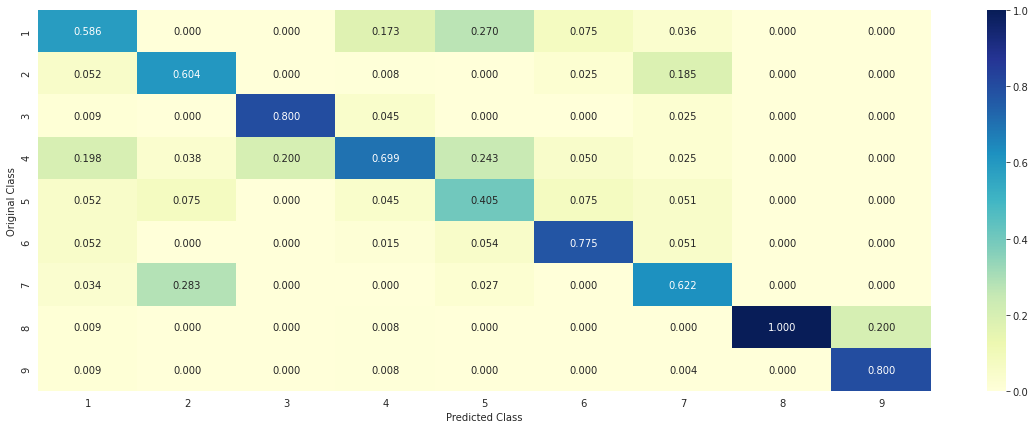

-------------------- Recall matrix (Row sum=1) --------------------


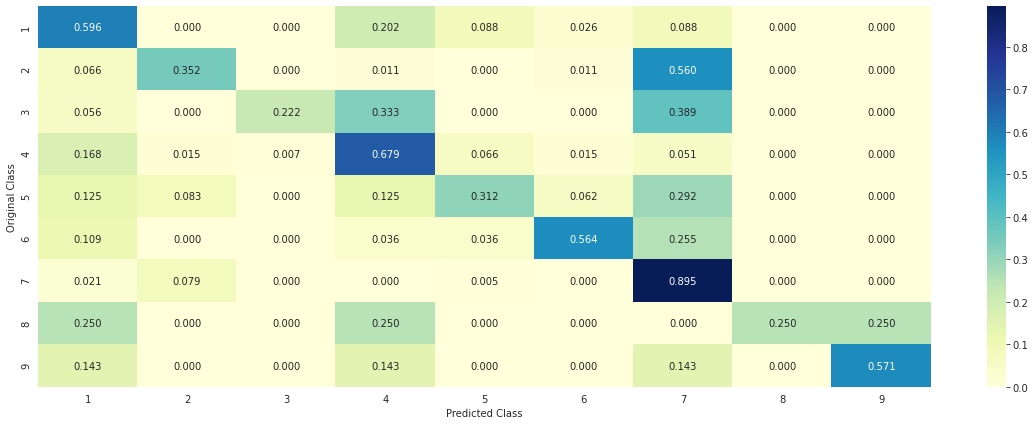

In [80]:
vclf = VotingClassifier(estimators=[('lr', calib_clf_LR), ('svc', calib_clf_SVM), ('rf', calib_clf_RF)], voting='soft', n_jobs = -1)
vclf.fit(train_x, train_y)
print("Log loss (train) on the VotingClassifier :"+str(np.round(log_loss(train_y, vclf.predict_proba(train_x), labels=vclf.classes_), 2)))
print("Log loss (CV) on the VotingClassifier :"+str(np.round(log_loss(cv_y, vclf.predict_proba(cv_x), labels=vclf.classes_), 2)))
print("Log loss (test) on the VotingClassifier :"+str(np.round(log_loss(test_y, vclf.predict_proba(test_x), labels=vclf.classes_), 2)))
print("Percentage of mis-classified for cv points :"+str(np.round((np.count_nonzero(vclf.predict(cv_x) - cv_y)/cv_x.shape[0]*100), 2))+"%")
print("Percentage of mis-classified for Test points :"+str(np.round((np.count_nonzero(vclf.predict(test_x) - test_y)/test_x.shape[0]*100), 2))+"%")
plot_confusion_matrix(test_y, vclf.predict(test_x))

In [ ]:
loss_table = loss_table.append(pd.DataFrame([["Voting Classifier", 0.64, 1.06, 1.13, "37.03%", "37.19%", "Goodfit"]], columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Remarks"]))

## Stacking Average Models

In [121]:
from mlxtend.classifier import StackingClassifier
cv_log_loss = []
alpha = [10**x for x in range(-3, 0)]
for i in alpha:
    lr = SGDClassifier(loss = "log", alpha = i)
    stack_clf = StackingClassifier(classifiers=[calib_clf_NB, calib_clf_LR, calib_clf_SVM, calib_clf_RF], meta_classifier=lr, use_probas=True)
    stack_clf.fit(train_x, train_y)
    cv_log_loss.append(log_loss(cv_y, stack_clf.predict_proba(cv_x)))
    print("Stacking Classifer : For alpha value: "+str(i)+" Log Loss: "+str(np.round(log_loss(cv_y, stack_clf.predict_proba(cv_x)), 4)))

Stacking Classifer : For alpha value: 0.001 Log Loss: 1.0909
Stacking Classifer : For alpha value: 0.01 Log Loss: 1.1268
Stacking Classifer : For alpha value: 0.1 Log Loss: 1.4654


In [123]:
best_alpha = alpha[np.argmin(cv_log_loss)]

lr = SGDClassifier(loss = "log", alpha = best_alpha)
stack_clf = StackingClassifier(classifiers=[calib_clf_NB, calib_clf_LR, calib_clf_SVM, calib_clf_RF], meta_classifier=lr, use_probas=True)
stack_clf.fit(train_x, train_y)

trainloss = log_loss(train_y, stack_clf.predict_proba(train_x))
print("Train Log Loss on Stacking Classifier =  "+str(np.round(trainloss, 4)))

cvloss = log_loss(cv_y, stack_clf.predict_proba(cv_x))
print("Cross Validation Log Loss on Stacking Classifier =  "+str(np.round(cvloss, 4)))

testloss = log_loss(test_y, stack_clf.predict_proba(test_x))
print("Test Log Loss on Stacking Classifier =  "+str(np.round(testloss, 4)))

print("Percentage of mis-classified for CV points = "+str(np.round((np.count_nonzero(stack_clf.predict(cv_x) - cv_y)/cv_x.shape[0]*100), 2))+"%")
print("Percentage of mis-classified for Test points = "+str(np.round((np.count_nonzero(stack_clf.predict(test_x) - test_y)/test_x.shape[0]*100), 2))+"%")

Train Log Loss on Stacking Classifier =  0.4212
Cross Validation Log Loss on Stacking Classifier =  1.0787
Test Log Loss on Stacking Classifier =  1.1446
Percentage of mis-classified for CV points = 36.47%
Percentage of mis-classified for Test points = 37.74%


-------------------- Confusion matrix --------------------


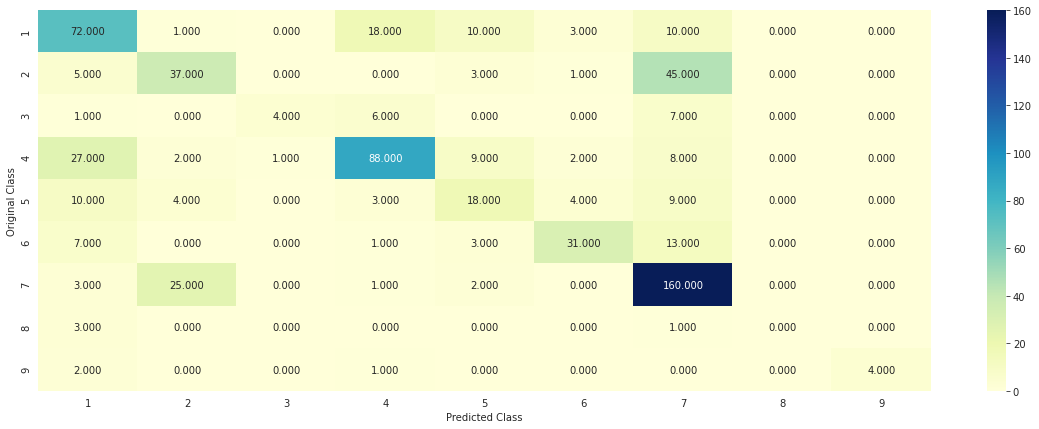

-------------------- Precision matrix (Columm Sum=1) --------------------


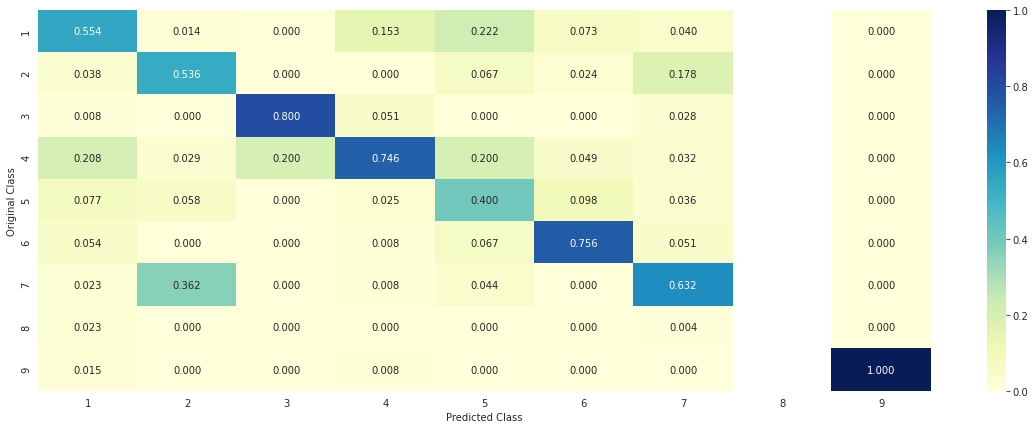

-------------------- Recall matrix (Row sum=1) --------------------


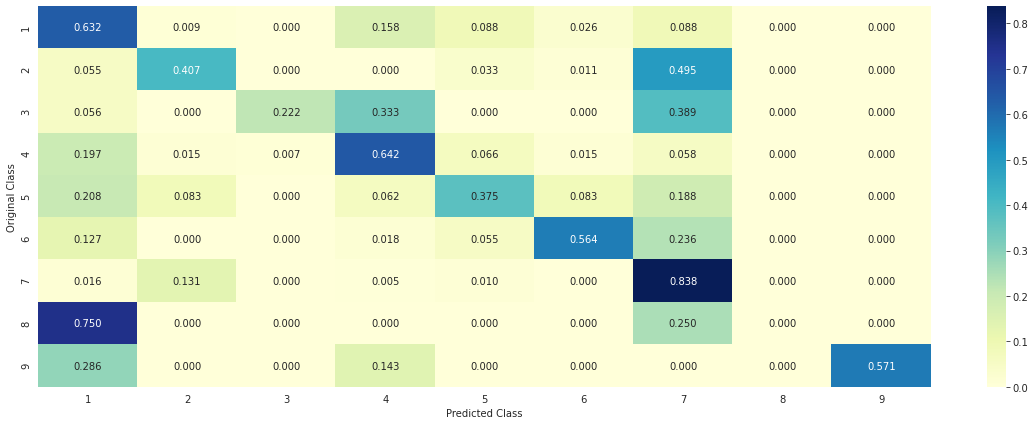

In [127]:
plot_confusion_matrix(test_y, stack_clf.predict(test_x))

In [124]:
loss_table = loss_table.append(pd.DataFrame([["Stacking Classifier", 0.421, 1.0787, 1.1446, "36.47%", "37.74%", "Goodfit"]], columns = ["Model", "Train Log-loss", "CV Log-loss", "Test Log-loss", "Mis-Classified CV", "Mis-Classified Test", "Remarks"]))

# Summary

In [125]:
loss_table

,Model,Train Log-loss,CV Log-loss,Test Log-loss,Mis-Classified CV,Mis-Classified Test,Remarks
0,Naive Bayes,0.9157,1.2169,1.3290,36.84%,42.86%,Overfit
0,KNearest Neighbors,0.9836,1.1685,1.1840,41.35%,43.76%,Goodfit
0,Logistic Regression,0.5630,1.1330,1.1610,36.09%,39.4%,Overfit
0,Linear SVM,0.7060,1.1807,1.2474,37.59%,39.85%,Goodfit
0,Random Forest,0.6830,1.1844,1.1265,35.53%,38.35%,Goodfit
0,Voting Classifier,0.6400,1.0600,1.1300,37.03%,37.19%,Goodfit
0,Stacking Classifier,0.4210,1.0787,1.1446,36.47%,37.74%,Goodfit


# Thank You